<h1><center> Paw Print <center><h1>
<img src='images/paw_print.png' width=200/>

# Project Overview
---
This project aims to create a model that can accurately predict a dog's breed given an image. Additionally it will output the top 5 breed predictions and the breed traits (including temperament, size, energy level, trainability, etc) of the predicted breed. 

Using Tensorflow's Pre-Trained Convolutional Neural Networks we were able to produce a model that had a prediction accuracy of 81% on test images. With further analysis we have determined that, 94% of the time, our model will classify an image as the correct breed within the top 5 predictions.

# Business Understanding
---
Every year over 3 million dogs end up in animal shelters. A study done in 2013 showed that shelter staff correctly visually identify breeds accurately 67% of the time, and that accuracy was exponentially lower for dogs that are mixed breeds. Additionally the number one question asked by people looking for dogs in a shelter is "what breed is that dog?" Creating a model that can predict a dogs breed given an image can be extremely useful for accurately classifying animals at animal shelters.

Creating a CNN model that can predict a dogs breed can be immensely useful for animal shelters to save time and resources, increase identification accuracy, and potentially lead to an increase in dog adoptions. 

## Data Understanding
---
AKC Dog Breed Traits: This dataset contains dog breed traits (temperament, height, weight, trainability, energy level, etc) for over 270 dog breeds. This dataset comes from https://github.com/tmfilho/akcdata and has been pre-processed in the dog_breed_preprocessing.ipynb (add link once published) notebook so that the dog breed labels are compatible with those from our images. 

Dog Breed Images and Labels: This dataset contains images of over 10,000 dogs from 120 different breeds, along with a dataframe containing each image name and their corresponding breed. This dataset comes from Kaggle https://www.kaggle.com/c/dog-breed-identification.

# Data Preparation

### Import Statements

In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.image import imread

import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, regularizers, models, optimizers, losses, experimental

from tensorflow.keras.applications import MobileNetV2, InceptionResNetV2
import tensorflow_hub as hub

In [2]:
# read in csv file containing file names and breeds
breed_df = pd.read_csv('data/dog-breed-identification/labels.csv')

In [3]:
breed_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
breed_df[breed_df['breed'] == 'dhole']

,id,breed
42,011e06760794850c40f23d6426c40774,dhole
133,032620ae0f847d957d94d1fd76cb17e8,dhole
257,060112a1a77217039de21f7d0963929d,dhole
372,08ea655aa168d87806340c336d07f1c9,dhole
516,0c71338af3f3a8c068ec28b5f6b8f8ae,dhole
...,...,...
9181,e6898f5cc43bb4a30970f2d2210fdb9a,dhole
9317,e9efc5edbe14eb6375a64b37db8b36df,dhole
9611,f1a18e29959bc5af735ebb5045f91b25,dhole
9618,f1f03709a6fb351e6255cabc277c5fc4,dhole


In [5]:
# both columns are object type
breed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [6]:
# number of images per breed range from 66-126
breed_df['breed'].value_counts() 

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

In [7]:
# get the directory for the training images
train_dir = 'data/dog-breed-identification/train/'

In [8]:
# add directory path and .jpg to each image name in dataframe  to make readable
breed_df['id'] = train_dir+breed_df['id']+'.jpg'

In [ ]:
# read in AKC breed dataset for later evaluation
akc_breeds = pd.read_csv('data/akc_breeds_final.csv')

In [10]:
akc_breeds

,Breed,temperament,popularity,min_height,max_height,min_weight,max_weight,min_expectancy,max_expectancy,group,grooming_frequency_value,grooming_frequency_category,shedding_value,shedding_category,energy_level_value,energy_level_category,trainability_value,trainability_category,demeanor_value,demeanor_category
0,affenpinscher,"Confident, Famously Funny, Fearless",148,22.86,29.21,3.175147,4.535924,12.0,15.0,Toy Group,0.6,2-3 Times a Week Brushing,0.6,Seasonal,0.6,Regular Exercise,0.8,Easy Training,1.0,Outgoing
1,afghan_hound,"Dignified, Profoundly Loyal, Aristocratic",113,63.50,68.58,22.679619,27.215542,12.0,15.0,Hound Group,0.8,Daily Brushing,0.2,Infrequent,0.8,Energetic,0.2,May be Stubborn,0.2,Aloof/Wary
2,airedale,"Friendly, Clever, Courageous",60,58.42,58.42,22.679619,31.751466,11.0,14.0,Terrier Group,0.6,2-3 Times a Week Brushing,0.4,Occasional,0.6,Regular Exercise,1.0,Eager to Please,0.8,Friendly
3,malamute,"Affectionate, Loyal, Playful",58,58.42,63.50,34.019428,38.555351,10.0,14.0,Working Group,0.6,2-3 Times a Week Brushing,0.6,Seasonal,0.8,Energetic,0.4,Independent,0.8,Friendly
4,boston_bull,"Loyal, Self-Confident",NaN,50.80,63.50,27.215542,45.359237,10.0,12.0,Foundation Stock Service,0.2,Occasional Bath/Brush,0.6,Seasonal,0.8,Energetic,0.6,Agreeable,0.6,Alert/Responsive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,whippet,"Affectionate, Playful, Calm",61,45.72,55.88,11.339809,18.143695,12.0,15.0,Hound Group,0.2,Occasional Bath/Brush,0.4,Occasional,0.6,Regular Exercise,0.4,Independent,0.4,Reserved with Strangers
116,wire-haired_fox_terrier,"Confident, Alert, Gregarious",101,38.10,38.10,6.803886,8.164663,12.0,15.0,Terrier Group,0.4,Weekly Brushing,0.2,Infrequent,0.6,Regular Exercise,0.6,Agreeable,0.6,Alert/Responsive
117,mexican_hairless,"Loyal, Alert, Calm",140,25.40,58.42,4.535924,24.947580,13.0,18.0,Non-Sporting Group,0.2,Occasional Bath/Brush,0.2,Infrequent,0.8,Energetic,0.6,Agreeable,0.6,Alert/Responsive
118,yorkshire_terrier,"Affectionate, Sprightly, Tomboyish",10,17.78,20.32,3.175147,3.175147,11.0,15.0,Toy Group,1.0,Specialty/Professional,0.2,Infrequent,0.6,Regular Exercise,0.2,May be Stubborn,0.8,Friendly


### Get the top 10 breeds and visualize a sample set of images

In [11]:
# get top 10 dog breeds
top_10 = breed_df['breed'].value_counts()[:10]
top_10

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
shih-tzu                112
great_pyrenees          111
pomeranian              111
basenji                 110
samoyed                 109
Name: breed, dtype: int64

In [12]:
# get the top 10 dog breeds for visualization
top_breed_images = []

for breed in top_10.index:
    breed_img = breed_df[breed_df['breed'] == breed].iloc[np.random.randint(len(breed_df[breed_df['breed'] == breed]))]
    top_breed_images.append(breed_img)

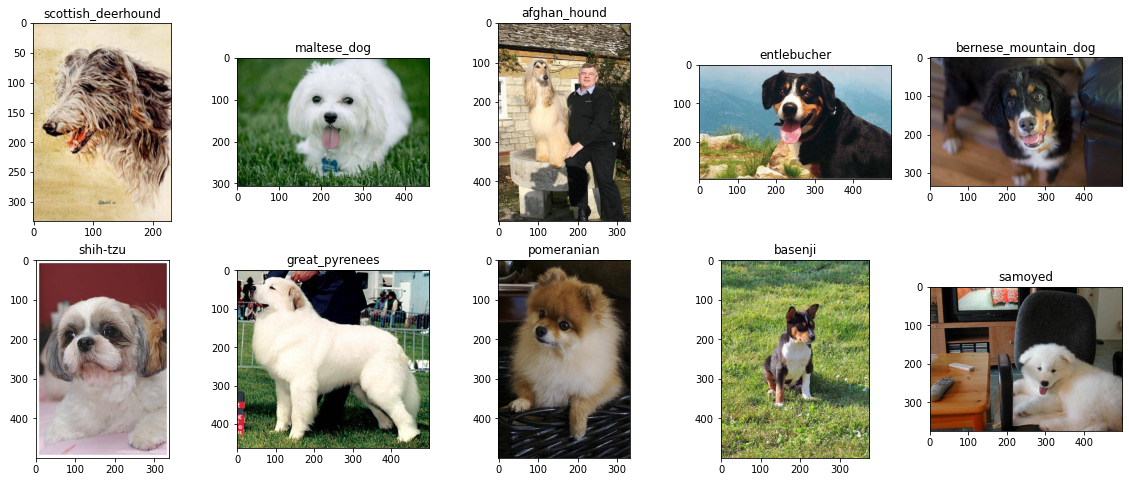

In [13]:
# visualize example images of the top 10 dog breeds
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20,8))

x = 0
for i in range(2):
    for j in range(5):
        im = plt.imread(top_breed_images[x]['id'])
        axes[i][j].imshow(im)
        axes[i][j].plot()
        axes[i][j].set_title(top_breed_images[x]['breed'])
        x += 1

### Split data frame into train and validation and use image data generator to create augmented images for modeling

In [14]:
train_df, val = train_test_split(breed_df, test_size=0.25, random_state=42)

In [15]:
val_df, test_df = train_test_split(val, test_size=0.10, random_state=42, stratify=val['breed'])

In [16]:
# use data augmentation on train split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

train_data = train_datagen.flow_from_dataframe( 
    train_df,
    x_col='id',
    y_col='breed',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32)

# do not use data augmentation on validation split
val_datagen = ImageDataGenerator(rescale = 1./255)
val_data = val_datagen.flow_from_dataframe(val_df,
                                             x_col = 'id',
                                             y_col = 'breed',
                                             target_size = (224,224),
                                             class_mode = 'categorical',
                                             batch_size = 32)

test_datagen = ImageDataGenerator(rescale = 1./255)
test_data = test_datagen.flow_from_dataframe(test_df,
                                             x_col = 'id',
                                             y_col = 'breed',
                                             target_size = (224,224),
                                             class_mode = 'categorical',
                                             batch_size = 32)


Found 7666 validated image filenames belonging to 120 classes.
Found 2300 validated image filenames belonging to 120 classes.
Found 256 validated image filenames belonging to 120 classes.


In [17]:
breed_classes = train_data.class_indices

In [18]:
breed_classes

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [19]:
train_images, train_labels = next(train_data)
val_images, val_labels = next(val_data)
test_images, test_labels = next(test_data)

In [143]:
train_images[0].shape

(224, 224, 3)

doberman


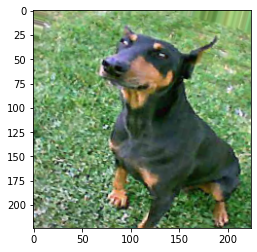

In [60]:
# show an example of how data augmentation affects images
plt.imshow(train_images[0]);
print(list(breed_classes)[np.argmax(train_labels[0])])

# Modeling
---

In [21]:
# define early stopping so our models will stop running if they're performance tapers off
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [22]:
# function plots the accuracy and loss of the train and val over epochs
def plot_model(results):
    
    history=results.history

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
    ax1.plot(history['loss'], label='Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.grid(False)
    ax1.legend()

    ax2.plot(history['acc'], label = 'Acc')
    ax2.plot(history['val_acc'], label='Val Acc')
    ax2.grid(False)
    ax2.legend();

In [169]:
# function takes y_pred and y_true and plots confusion matrix
def plot_confusion_matrix(model, test_images, test_labels):
    predictions = np.array(model.predict(test_images))

    y_pred = [np.argmax(pred, -1) for pred in predictions]
    y_true = [np.argmax(label) for label in test_labels]
    
    cm = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(10,10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    ax.grid(False)
    #ax.show();

### Baseline Model: Tensorflow Pre-trained MobileNetV2 model
Using MobileNetV2 because it is the most efficient model to use in a mobile app. This is becasue it is faster and smaller than other models. It can be known to sacrifice some accuracy, though I tried other models and MobileNetV2 was the most accurate on this data. 

In [24]:
mobilenet = MobileNetV2(input_shape = (224,224,3),include_top=False, weights='imagenet')

mobilenet.trainable = False
baseline_model = models.Sequential()

baseline_model.add(mobilenet)
baseline_model.add(layers.Flatten())
baseline_model.add(layers.Dense(120, activation='softmax'))

baseline_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['acc'])

In [25]:
baseline_results = baseline_model.fit(train_data, 
                                      validation_data = val_data, 
                                      epochs = 10, 
                                      callbacks=[early_stopping])

Epoch 1/10
240/240 [==============================] - 196s 816ms/step - loss: 14.2520 - acc: 0.4373 - val_loss: 12.9335 - val_acc: 0.5543
Epoch 2/10
240/240 [==============================] - 205s 853ms/step - loss: 8.7440 - acc: 0.6544 - val_loss: 12.9462 - val_acc: 0.5974
Epoch 3/10
240/240 [==============================] - 207s 862ms/step - loss: 7.0523 - acc: 0.7352 - val_loss: 14.7719 - val_acc: 0.6178
Epoch 4/10
240/240 [==============================] - 217s 906ms/step - loss: 5.8247 - acc: 0.7829 - val_loss: 15.6233 - val_acc: 0.6239
Epoch 5/10
240/240 [==============================] - 207s 863ms/step - loss: 5.0852 - acc: 0.8153 - val_loss: 17.3016 - val_acc: 0.6296
Epoch 6/10
240/240 [==============================] - 214s 891ms/step - loss: 4.4219 - acc: 0.8446 - val_loss: 19.5166 - val_acc: 0.6217


In [26]:
test_eval = baseline_model.evaluate(test_data)

8/8 [==============================] - 4s 531ms/step - loss: 20.2255 - acc: 0.6094


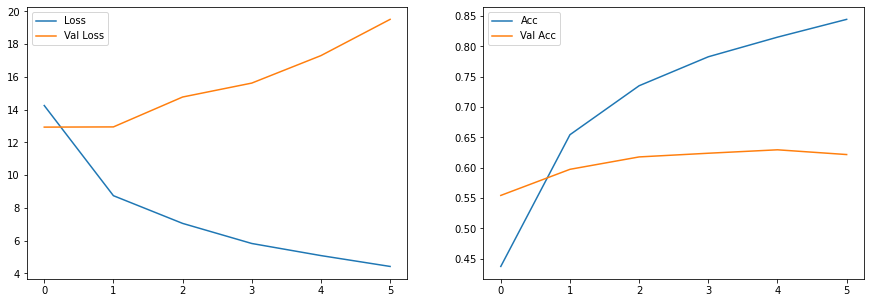

In [27]:
plot_model(baseline_results)

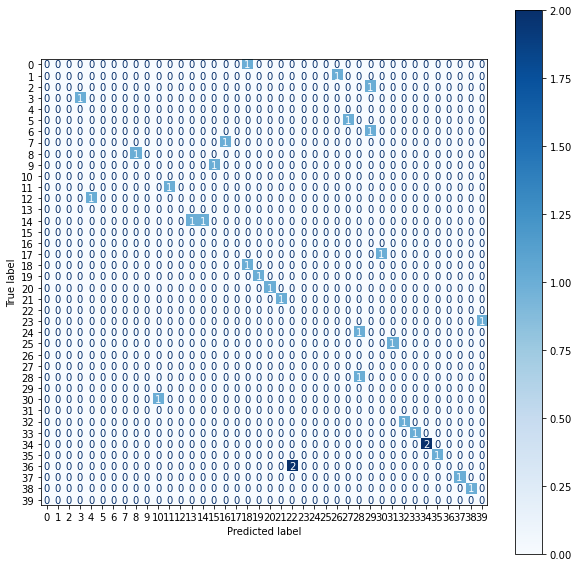

In [170]:
plot_confusion_matrix(baseline_model, test_images, test_labels)

### Tuned MobileNetV2 model
We can see by our validation loss and accuracy that our model is clearly overfitting on our training data, so lets add some other layers and dropout to see if we can fix that

In [28]:
mobilenet = MobileNetV2(input_shape = (224,224,3),include_top=False, weights='imagenet')

mobilenet.trainable = False
trained_model = models.Sequential()

trained_model.add(mobilenet)
trained_model.add(layers.GlobalAveragePooling2D())
trained_model.add(layers.Dense(512, activation = 'relu'))
trained_model.add(layers.Dropout(0.5))
trained_model.add(layers.Dense(120, activation='softmax'))

trained_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['acc'])

In [29]:
trained_results = trained_model.fit(train_data, 
                             validation_data = val_data, 
                             epochs = 10, 
                             callbacks=[early_stopping])

Epoch 1/10
240/240 [==============================] - 213s 887ms/step - loss: 2.6638 - acc: 0.3656 - val_loss: 1.1952 - val_acc: 0.6674
Epoch 2/10
240/240 [==============================] - 215s 894ms/step - loss: 1.4878 - acc: 0.5811 - val_loss: 1.0506 - val_acc: 0.6909
Epoch 3/10
240/240 [==============================] - 215s 895ms/step - loss: 1.2280 - acc: 0.6393 - val_loss: 0.9945 - val_acc: 0.6948
Epoch 4/10
240/240 [==============================] - 209s 869ms/step - loss: 1.1360 - acc: 0.6593 - val_loss: 0.9732 - val_acc: 0.7083
Epoch 5/10
240/240 [==============================] - 212s 882ms/step - loss: 1.0553 - acc: 0.6807 - val_loss: 0.9640 - val_acc: 0.7091
Epoch 6/10
240/240 [==============================] - 215s 896ms/step - loss: 0.9787 - acc: 0.7040 - val_loss: 0.9605 - val_acc: 0.7222
Epoch 7/10
240/240 [==============================] - 214s 891ms/step - loss: 0.9356 - acc: 0.7193 - val_loss: 0.9387 - val_acc: 0.7178
Epoch 8/10
240/240 [============================

In [30]:
test_eval = trained_model.evaluate(test_data)

8/8 [==============================] - 4s 484ms/step - loss: 1.0243 - acc: 0.7148


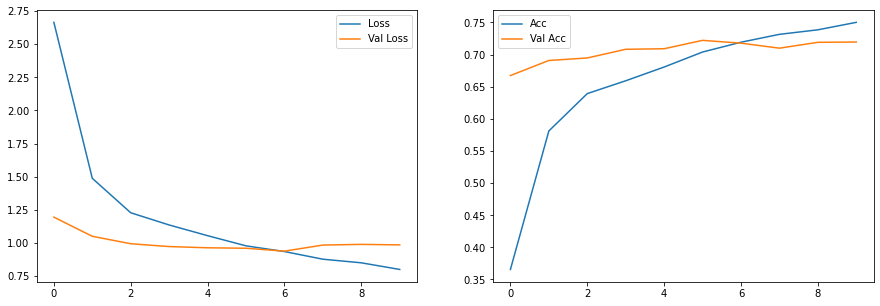

In [31]:
plot_model(trained_results)

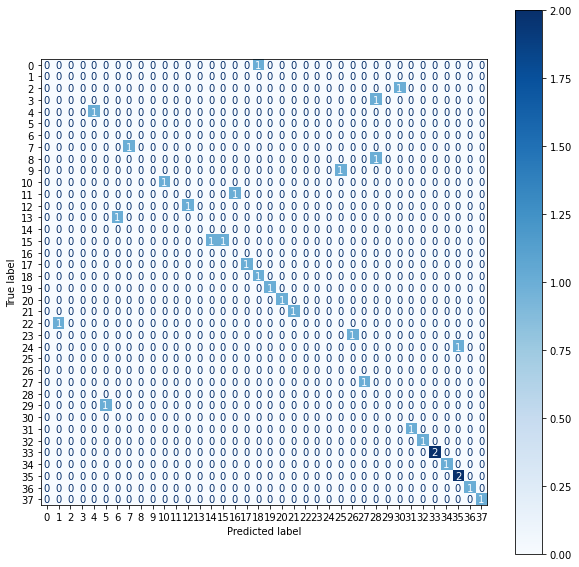

In [171]:
plot_confusion_matrix(trained_model, test_images, test_labels)

### Try adding BatchNormalization to see if that improves our model at all

In [32]:
mobilenet = MobileNetV2(input_shape = (224,224,3),include_top=False, weights='imagenet')

mobilenet.trainable = False
trained_model2 = models.Sequential()

trained_model2.add(mobilenet)
trained_model2.add(layers.GlobalAveragePooling2D())
trained_model2.add(layers.Dense(512, activation = 'relu'))
trained_model2.add(layers.BatchNormalization())
trained_model2.add(layers.Dropout(0.5))
trained_model2.add(layers.Dense(120, activation='softmax'))

trained_model2.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['acc'])

In [33]:
trained_results2 = trained_model2.fit(train_data, 
                             validation_data = val_data, 
                             epochs = 10, 
                             callbacks=[early_stopping])

Epoch 1/10
240/240 [==============================] - 203s 846ms/step - loss: 2.3060 - acc: 0.4427 - val_loss: 1.1466 - val_acc: 0.6700
Epoch 2/10
240/240 [==============================] - 204s 851ms/step - loss: 1.2833 - acc: 0.6316 - val_loss: 1.0909 - val_acc: 0.6852
Epoch 3/10
240/240 [==============================] - 200s 832ms/step - loss: 1.0574 - acc: 0.6912 - val_loss: 1.0291 - val_acc: 0.6952
Epoch 4/10
240/240 [==============================] - 208s 865ms/step - loss: 0.9259 - acc: 0.7237 - val_loss: 1.0479 - val_acc: 0.6970
Epoch 5/10
240/240 [==============================] - 210s 875ms/step - loss: 0.8670 - acc: 0.7342 - val_loss: 1.0101 - val_acc: 0.7117
Epoch 6/10
240/240 [==============================] - 205s 853ms/step - loss: 0.7776 - acc: 0.7589 - val_loss: 1.0325 - val_acc: 0.7004
Epoch 7/10
240/240 [==============================] - 207s 860ms/step - loss: 0.7566 - acc: 0.7643 - val_loss: 1.0714 - val_acc: 0.6943
Epoch 8/10
240/240 [============================

In [34]:
test_eval = trained_model2.evaluate(test_data)

8/8 [==============================] - 4s 493ms/step - loss: 1.1340 - acc: 0.6758


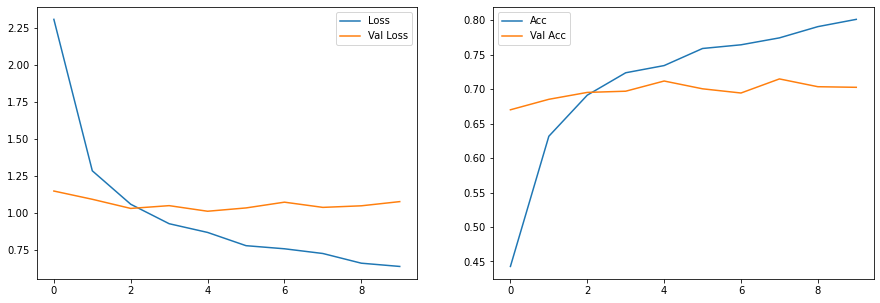

In [35]:
plot_model(trained_results2)

#### We have significantly reduced our loss and we have improved accuracy but we are still seeing overfitting. Lets use the tensorflow hub version of MobileNetV2 to see if we can improve accuracy more and reduce overfitting

### Tensorflow Hub MobileNet V2 

In [36]:
mobilenet_model = hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4")

mobilenet_hub = models.Sequential([mobilenet_model, 
                          layers.Dense(units=120, activation="softmax")])

mobilenet_hub.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics = ['acc'])


In [37]:
hub_results = mobilenet_hub.fit(train_data,
                        epochs=10,
                        validation_data=val_data,
                        validation_freq=1, 
                        callbacks=early_stopping)

Epoch 1/10
240/240 [==============================] - 213s 889ms/step - loss: 1.8558 - acc: 0.5557 - val_loss: 0.8529 - val_acc: 0.7474
Epoch 2/10
240/240 [==============================] - 228s 948ms/step - loss: 0.7132 - acc: 0.7883 - val_loss: 0.7667 - val_acc: 0.7657
Epoch 3/10
240/240 [==============================] - 232s 965ms/step - loss: 0.5226 - acc: 0.8394 - val_loss: 0.7456 - val_acc: 0.7730
Epoch 4/10
240/240 [==============================] - 222s 927ms/step - loss: 0.4393 - acc: 0.8632 - val_loss: 0.7554 - val_acc: 0.7743
Epoch 5/10
240/240 [==============================] - 219s 915ms/step - loss: 0.3693 - acc: 0.8809 - val_loss: 0.7587 - val_acc: 0.7809
Epoch 6/10
240/240 [==============================] - 202s 842ms/step - loss: 0.3081 - acc: 0.9018 - val_loss: 0.8020 - val_acc: 0.7626
Epoch 7/10
240/240 [==============================] - 203s 847ms/step - loss: 0.2990 - acc: 0.9043 - val_loss: 0.8119 - val_acc: 0.7770
Epoch 8/10
240/240 [============================

In [176]:
test_eval = mobilenet_hub.evaluate(test_data)

8/8 [==============================] - 5s 632ms/step - loss: 0.8937 - acc: 0.7812


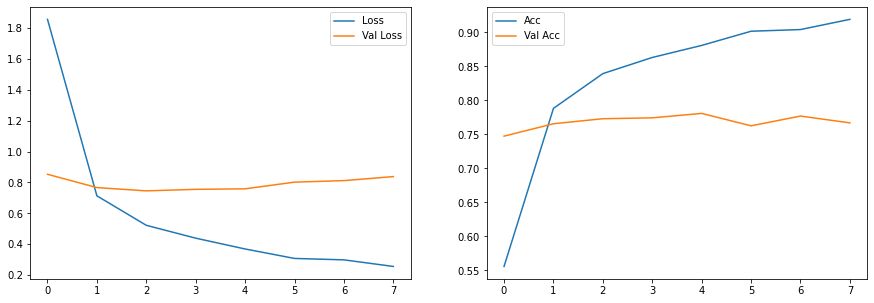

In [39]:
plot_model(hub_results)

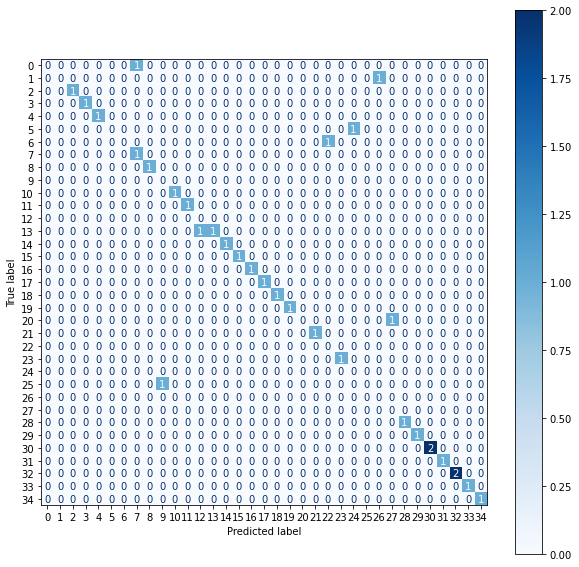

In [174]:
plot_confusion_matrix(mobilenet_hub, test_images, test_labels)

In [40]:
# mobilenet_model = hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4")

# mobilenet_hub2 = models.Sequential([mobilenet_model, 
#                           layers.Dense(units=120, activation="softmax")])

# mobilenet_hub2.compile(optimizer='adam', 
#               loss='categorical_crossentropy',
#               metrics = ['acc'])


In [41]:
# hub_results2 = mobilenet_hub2.fit(train_data,
#                         epochs=10,
#                         validation_data=val_data,
#                         validation_freq=1, 
#                         callbacks=early_stopping)

In [173]:
#test_eval = mobilenet_hub2.evaluate(test_data)

NameError: name 'mobilenet_hub2' is not defined

In [43]:
#plot_model(hub_results2)

In [44]:
#plot_confusion_matrix(mobilenet_hub2, test_labels, test_images)

#### MobileNetV2 Hub gave us the best results. We will consider this to be our final model and save it to be used in our mobile app. Let's test it out on some test images to see how well it performs.

In [194]:
# save model
# mobilenet_hub.save('data/models/mobilenet_hub.h5')

### InceptionResNetV2
Test out another pre-trained model to see how it's performance compares to MobileNetV2

In [50]:
inception = InceptionResNetV2(include_top = False, weights ='imagenet', input_shape = (224,224,3))
inception.trainable = False

inception_model = models.Sequential()
inception_model.add(inception)
inception_model.add(layers.GlobalAveragePooling2D())
inception_model.add(layers.Dense(512,activation='relu'))
inception_model.add(layers.Dropout(0.5))

inception_model.add(layers.Dense(120,activation = 'softmax'))

inception_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics = ['acc'])

In [51]:
inception_report = inception_model.fit(train_data,
                    epochs = 5,
                    validation_data = val_data,
                    callbacks = early_stopping)

Epoch 1/5
240/240 [==============================] - 618s 3s/step - loss: 1.6262 - acc: 0.6488 - val_loss: 0.6569 - val_acc: 0.8130
Epoch 2/5
240/240 [==============================] - 619s 3s/step - loss: 0.9875 - acc: 0.7518 - val_loss: 0.6667 - val_acc: 0.8117
Epoch 3/5
240/240 [==============================] - 812s 3s/step - loss: 0.9524 - acc: 0.7533 - val_loss: 0.6711 - val_acc: 0.8100
Epoch 4/5
240/240 [==============================] - 955s 4s/step - loss: 0.9080 - acc: 0.7634 - val_loss: 0.6884 - val_acc: 0.8178
Epoch 5/5
240/240 [==============================] - 966s 4s/step - loss: 0.8555 - acc: 0.7713 - val_loss: 0.6518 - val_acc: 0.8226


In [52]:
test_eval = inception_model.evaluate(test_data)

8/8 [==============================] - 21s 3s/step - loss: 0.6420 - acc: 0.8164


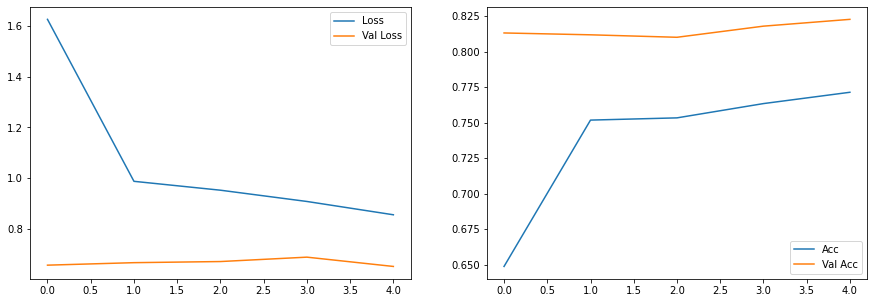

In [53]:
plot_model(inception_report)

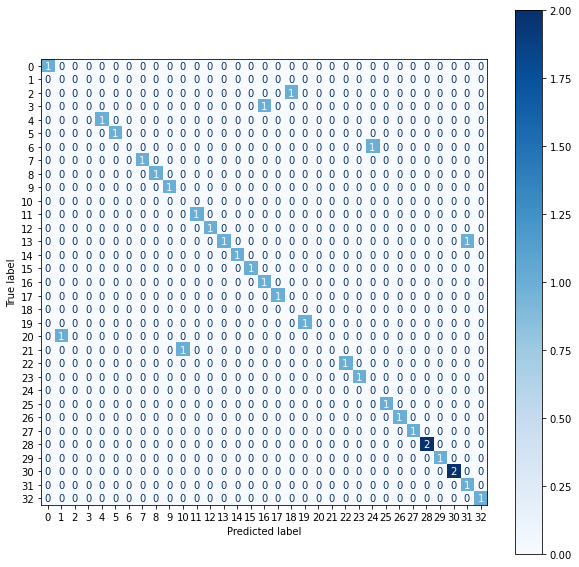

In [175]:
plot_confusion_matrix(inception_model, test_images, test_labels)

#### Gives higher validation accuracy and lower validation loss, but performed worse on training accuracy and loss. Also when tested of sample images, correctly identified breeds at similar rate as MobileNetV2, but at much lower percentages. (MobileNetV2 would categorize breed at 91% and InceptionResNetV2 would categorize correctly but only at 23%). We will sick with MobileNetV2 as our final model because of it's relatively high accuract as well as it's speed. 

# Evaluation
---
We will use MobileNetV2 Hub for our final model. Below we will create a function that plots predictions and gives breed traits for any input test images. 

In [195]:
saved_mobilenet = models.load_model(('data/models/mobilenet_hub.h5'), custom_objects={'KerasLayer':hub.KerasLayer})

OSError: SavedModel file does not exist at: /var/folders/vm/q54rwsns6tn7t8_82jc4cx780000gn/T/tfhub_modules/87c08e811d90a898c320e6626614764b3f4e562b/{saved_model.pbtxt|saved_model.pb}

TypeError: 'NoneType' object is not subscriptable

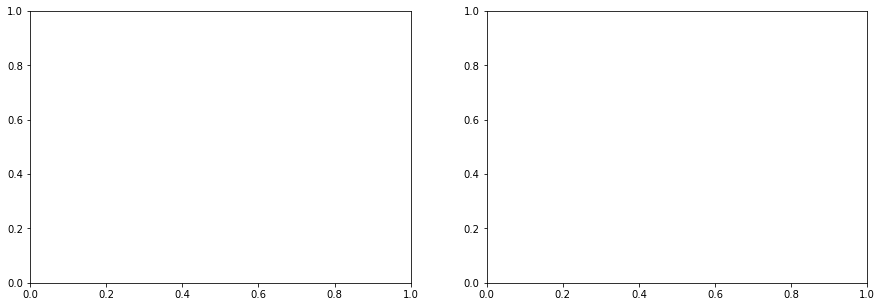

In [179]:
plot_model(saved_mobilenet)

In [ ]:
plot_confusion_matrix(saved_mobilenet, test_images, test_labels)

In [114]:
# create a function that will print out breed traits
def get_temperament(prediction):
    breed_name = prediction.replace('_', ' ').title()
    
    breed = akc_breeds[akc_breeds['Breed'] == prediction]
    temp = breed['temperament'].values[0]
    pop = breed['popularity'].values[0]
    avg_height = (breed['min_height'].values[0] + breed['max_height'].values[0]) / 2
    avg_weight = (breed['min_weight'].values[0] + breed['max_weight'].values[0]) / 2
    energy = breed['energy_level_value'].values[0]*10
    group = breed['group'].values[0]
    
    print(f"Breed: {breed_name}")
    print(f"Breed Group: {group}")
    print(f"Temperament: {temp}")
    print(f"Popularity: {pop}/270")
    print(f"Average Height: {round(avg_height, 2)} inches")
    print(f"Average Weight: {round(avg_weight, 2)} lbs")
    print(f"Energy Level: {int(energy)}/10")


In [115]:
# create a function that processes an input image into usable format for prediction
def predict_input(image_path, model, label='None'):
    # turn breed classes into a list
    
    if label == 'None' or label not in breed_classes:
        label == 'None'
    
    breeds = list(breed_classes)
        
    #plot image
    plt.figure()
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.axis('off')
    
    #predict image
    photo = load_img(test_dog, target_size=(224, 224))
    photo = img_to_array(photo)/255
    reshape_image = np.reshape(photo, [1, photo.shape[0], photo.shape[1], 3])
    predictions = np.array(model.predict(reshape_image))
    predicted_class = np.argmax(predictions, -1)
        
    # plot prediction class and percentage
    plt.title(f"Breed Prediction: {np.max(predictions)*100:.1f}% {breeds[predicted_class[0]]}\n", fontsize=15)

    # get top 5 breed predictions
    top_preds = predictions[0].argsort()[-5:][::-1]
    top_breeds = []
    for n in top_preds:
        top_breeds.append([breeds[n], predictions[0][n]])
        
    # plot top 5 predictions and their percentages 
    color = ['green' if (x[0] == label) else 'grey' for x in top_breeds]
    
    plt.figure()
    plt.bar([n[0] for n in top_breeds], [m[1] for m in top_breeds], color=color)
    plt.xticks(rotation=45)
    
    
   # get the top 10 dog breeds for visualization
#     fig, ax = plt.subplots(ncols=5, nrows=1, figsize=(15, 5))
    
#     for x in range(len(top_breeds)):
#         breed_img = breed_df[breed_df['breed'] == top_breeds[x][0]].iloc[0]
#         image = plt.imread(breed_img['id'])
#         ax[x].imshow(image)
#         ax[x].axis('off')
#         ax[x].set_title(top_breeds[x][0])
        
    # get breed info from AKC dataframe
    get_temperament(breeds[predicted_class[0]])
    
        
    return predictions

Breed: Rhodesian Ridgeback
Breed Group: Hound Group
Temperament: Affectionate, Dignified, Even-Tempered
Popularity: 41/270
Average Height: 64.77 inches
Average Weight: 35.15 lbs
Energy Level: 6/10


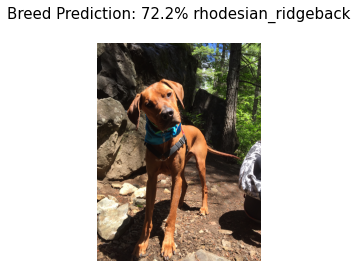

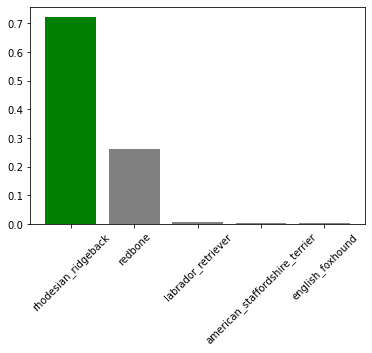

In [197]:
test_dog = 'data/test_dogs/IMG_4463.jpg'
pred_dog = predict_input(test_dog, mobilenet_hub, 'rhodesian_ridgeback')

In [151]:
# create a function that determines the accuracy of our model within 5 prediction. 
# Aka: how often does our model correctly guess the breed within the top 5 predictions
def accuracy_within_5(model, test_images, test_labels):
    num_tests = len(test_images)
    num_correct = 0 
    
    # iterate through the test images
    for i in range(num_tests):
        img = test_images[i]
        reshape_image = np.reshape(img, [1, img.shape[0], img.shape[1], 3])
        predictions = np.array(model.predict(reshape_image))
        
        #get top 5 predictions
        top_preds = predictions[0].argsort()[-5:][::-1]
        
        #if correct label is in the top 5, add 1 to number of correct
        if np.argmax(test_labels[i]) in top_preds:
            num_correct += 1
    
    # return as percentage of total number test
    return round(num_correct/num_tests, 2)  

In [153]:
top_accuracy = accuracy_within_5(mobilenet_hub, test_images, test_labels)

print(f"Accuracy of model within top 5 predictions: {top_accuracy*100}%")

Accuracy of model within top 5 predictions: 94.0%


# Conclusion
---

We have created a model that will predict a dog's breed with an accuracy of 78%. Further analysis shows that our model was actually able to classify the correct breed within the top 5 predictions at a 94% accuracy rate. We can conclude that our final model's 78% accuracy is an improvement over the current 67% accuracy of shelter's visual identification.

To guarantee best results, we recommend the input image be good lighting, without any image noise, and presents any distinguishable features of the dog. While testing out images, these types of images had a much higher success rate for being accurately classified. Similarly this model performed much better on images of dogs that are purebred, but still maintained some accuracy for dogs that are mixed-breed. 

# Next Steps
--- 

Given more time and resources I would love to collect more training data so to work towards increasing our models accuracy. While our model has performed relatively well on being able to accurately classify 120 dog breeds, for this model to be the most useful for animal shelters it will have to improve accuracy on any mixed-breed dogs, since more often dogs in shelters are mixed-breed and not purebred. 